In [1]:
import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report,accuracy_score
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from pylab import rcParams
rcParams['figure.figsize']=14,8
RANDOM_SEED=42
LABELS={'Normal,Fraud'}

In [2]:
data=pd.read_csv("C:\\Users\\SUHAS R S\\Downloads\\fraudTest.csv\\fraudTest.csv",sep=",")
data.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2020-06-21 12:14:25,2291163933867244,fraud_Kirlin and Sons,personal_care,2.86,Jeff,Elliott,M,351 Darlene Green,...,33.9659,-80.9355,333497,Mechanical engineer,1968-03-19,2da90c7d74bd46a0caf3777415b3ebd3,1371816865,33.986391,-81.200714,0
1,1,2020-06-21 12:14:33,3573030041201292,fraud_Sporer-Keebler,personal_care,29.84,Joanne,Williams,F,3638 Marsh Union,...,40.3207,-110.4360,302,"Sales professional, IT",1990-01-17,324cc204407e99f51b0d6ca0055005e7,1371816873,39.450498,-109.960431,0
2,2,2020-06-21 12:14:53,3598215285024754,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,Ashley,Lopez,F,9333 Valentine Point,...,40.6729,-73.5365,34496,"Librarian, public",1970-10-21,c81755dbbbea9d5c77f094348a7579be,1371816893,40.495810,-74.196111,0
3,3,2020-06-21 12:15:15,3591919803438423,fraud_Haley Group,misc_pos,60.05,Brian,Williams,M,32941 Krystal Mill Apt. 552,...,28.5697,-80.8191,54767,Set designer,1987-07-25,2159175b9efe66dc301f149d3d5abf8c,1371816915,28.812398,-80.883061,0
4,4,2020-06-21 12:15:17,3526826139003047,fraud_Johnston-Casper,travel,3.19,Nathan,Massey,M,5783 Evan Roads Apt. 465,...,44.2529,-85.0170,1126,Furniture designer,1955-07-06,57ff021bd3f328f8738bb535c302a31b,1371816917,44.959148,-85.884734,0


In [3]:
non_numeric_columns = data.select_dtypes(exclude=['number']).columns

print("Non-Numeric Columns:")
print(non_numeric_columns)


Non-Numeric Columns:
Index(['trans_date_trans_time', 'merchant', 'category', 'first', 'last',
       'gender', 'street', 'city', 'state', 'job', 'dob', 'trans_num'],
      dtype='object')


In [4]:
from sklearn.preprocessing import LabelEncoder

# Columns containing textual data
categorical_columns = ['merchant', 'category', 'gender', 'street', 'job', 'dob', 'trans_num','city', 'state']

# Label Encoding: Convert categorical values into numerical labels
label_encoder = LabelEncoder()
for col in categorical_columns:
    data[col] = label_encoder.fit_transform(data[col])

# Now, categorical columns are converted to numerical labels

# For 'category' column,considering one-hot encoding
data = pd.get_dummies(data, columns=['category'], prefix=['category'])




In [5]:
# Droping the 'first' and 'last' columns
columns_to_drop = ['first', 'last']
data.drop(columns=columns_to_drop, inplace=True)




In [6]:
# Convert the timestamp column to a pandas datetime object
data['trans_date_trans_time'] = pd.to_datetime(data['trans_date_trans_time'])

# Extract relevant components of the timestamp
data['year'] = data['trans_date_trans_time'].dt.year
data['month'] = data['trans_date_trans_time'].dt.month
data['day'] = data['trans_date_trans_time'].dt.day
data['hour'] = data['trans_date_trans_time'].dt.hour
data['minute'] = data['trans_date_trans_time'].dt.minute
data['second'] = data['trans_date_trans_time'].dt.second

# Drop the original timestamp column
data.drop(columns=['trans_date_trans_time'], inplace=True)



In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 555719 entries, 0 to 555718
Data columns (total 39 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Unnamed: 0   555719 non-null  int64  
 1   cc_num       555719 non-null  int64  
 2   merchant     555719 non-null  int32  
 3   amt          555719 non-null  float64
 4   gender       555719 non-null  int32  
 5   street       555719 non-null  int32  
 6   city         555719 non-null  int32  
 7   state        555719 non-null  int32  
 8   zip          555719 non-null  int64  
 9   lat          555719 non-null  float64
 10  long         555719 non-null  float64
 11  city_pop     555719 non-null  int64  
 12  job          555719 non-null  int32  
 13  dob          555719 non-null  int32  
 14  trans_num    555719 non-null  int32  
 15  unix_time    555719 non-null  int64  
 16  merch_lat    555719 non-null  float64
 17  merch_long   555719 non-null  float64
 18  is_fraud     555719 non-

In [8]:
data.isnull().values.any()

False

Text(0, 0.5, 'Frequency')

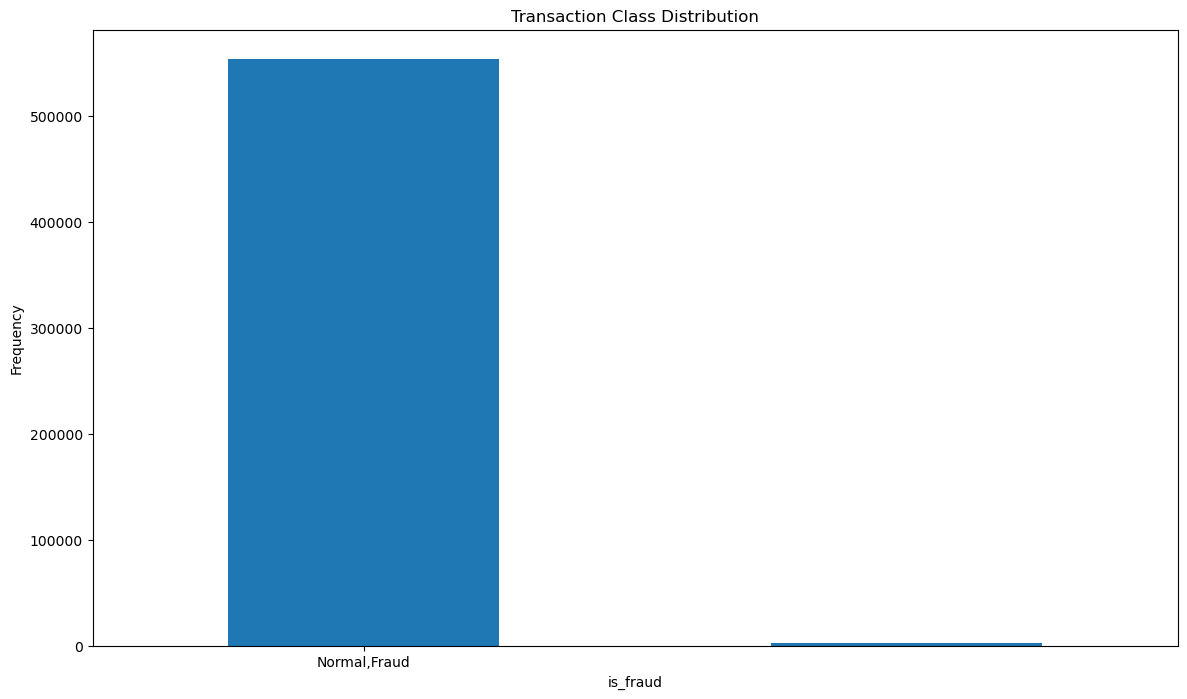

In [9]:
count_classes=pd.value_counts(data['is_fraud'],sort=True)

count_classes.plot(kind="bar", rot=0)

plt.title("Transaction Class Distribution")

plt.xticks(range(1), LABELS)
plt.xlabel("is_fraud")

plt.ylabel("Frequency")

In [10]:
## Get the fraud and norma dataset

fraud=data[data['is_fraud']==1]

normal=data[data['is_fraud']==0]

In [11]:
print(fraud.shape,normal.shape)

(2145, 39) (553574, 39)


In [12]:
## We need to analyze more amount of inforation from the transaction data
## How different are the amount of money used in different transaction classes?

fraud.amt.describe()

count    2145.000000
mean      528.356494
std       392.747594
min         1.780000
25%       214.510000
50%       371.940000
75%       907.770000
max      1320.920000
Name: amt, dtype: float64

In [13]:
normal.amt.describe()

count    553574.000000
mean         67.614408
std         152.471931
min           1.000000
25%           9.600000
50%          47.150000
75%          82.620000
max       22768.110000
Name: amt, dtype: float64

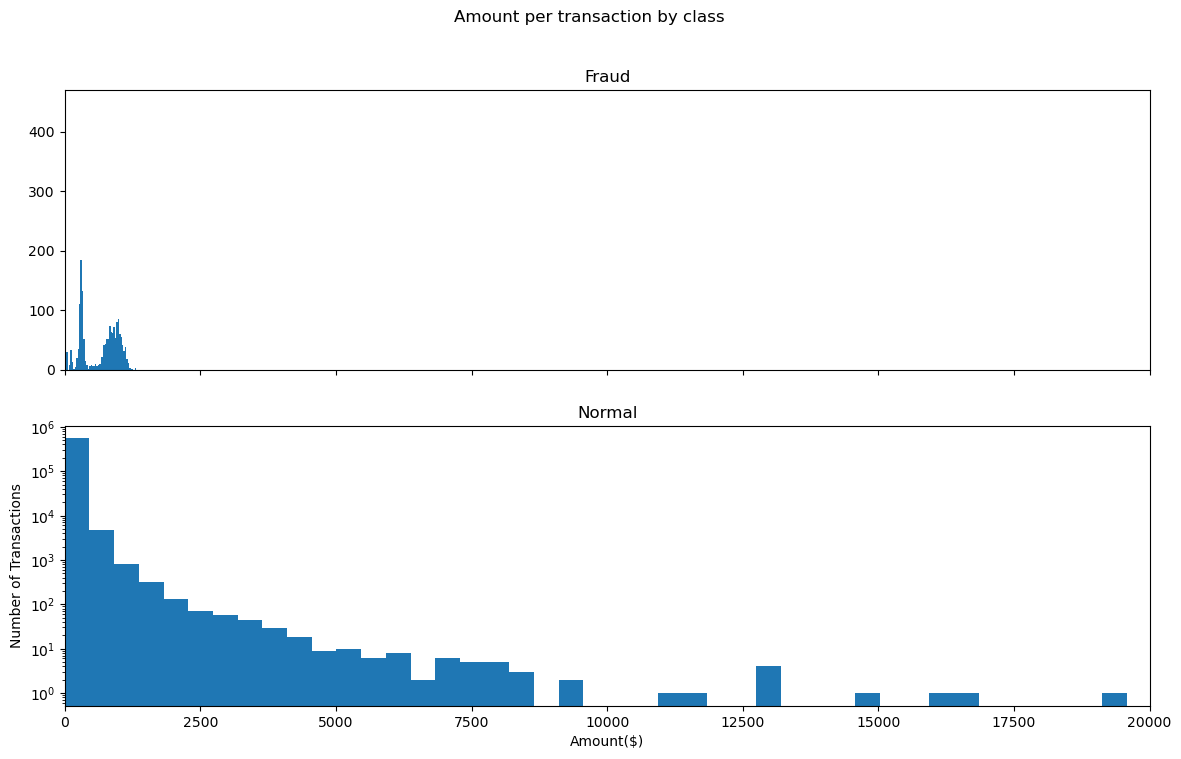

In [14]:
f,(ax1,ax2)=plt.subplots(2,1,sharex=True)
f.suptitle('Amount per transaction by class')
bins=50
ax1.hist(fraud.amt,bins=bins)
ax1.set_title('Fraud')
ax2.hist(normal.amt, bins = bins)
ax2.set_title('Normal')
plt.xlabel('Amount($)')
plt.ylabel('Number of Transactions')
plt.xlim((0,20000))
plt.yscale('log')
plt.show();

In [15]:
## Take some sample of the data

data1= data.sample(frac = 0.1,random_state=1)

data1.shape

(55572, 39)

In [16]:
#Determine the number of fraud and valid transactions in the dataset

Fraud = data1[data1['is_fraud']==1]

Valid = data1[data1['is_fraud']==0]

outlier_fraction = len(Fraud)/float(len(Valid))

In [17]:
print(outlier_fraction)

print("Fraud Cases : {}".format(len(Fraud)))

print("Valid Cases : {}".format(len(Valid)))

0.004337453914552158
Fraud Cases : 240
Valid Cases : 55332


In [18]:
#Create independent and Dependent Features
columns = data1.columns.tolist()
# Filter the columns to remove data we do not want 
columns = [c for c in columns if c not in ["is_fraud"]]
# Store the variable we are predicting 
target = "is_fraud"
# Define a random state 
state = np.random.RandomState(42)
X = data1[columns]
Y = data1[target]
X_outliers = state.uniform(low=0, high=1, size=(X.shape[0], X.shape[1]))
# Print the shapes of X & Y
print(X.shape)
print(Y.shape)

(55572, 38)
(55572,)


In [19]:
##Define the outlier detection methods

classifiers = {
    "Isolation Forest":IsolationForest(n_estimators=100, max_samples=len(X), 
                                       contamination=outlier_fraction,random_state=state, verbose=0),
    "Local Outlier Factor":LocalOutlierFactor(n_neighbors=20, algorithm='auto', 
                                              leaf_size=30, metric='minkowski',
                                              p=2, metric_params=None, contamination=outlier_fraction),
    "Support Vector Machine":OneClassSVM(kernel='rbf', degree=3, gamma=0.1,nu=0.05, 
                                         max_iter=-1)
   
}

In [20]:
type(classifiers)

dict

In [21]:
data.columns

Index(['Unnamed: 0', 'cc_num', 'merchant', 'amt', 'gender', 'street', 'city',
       'state', 'zip', 'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num',
       'unix_time', 'merch_lat', 'merch_long', 'is_fraud', 'category_0',
       'category_1', 'category_2', 'category_3', 'category_4', 'category_5',
       'category_6', 'category_7', 'category_8', 'category_9', 'category_10',
       'category_11', 'category_12', 'category_13', 'year', 'month', 'day',
       'hour', 'minute', 'second'],
      dtype='object')

In [ ]:
n_outliers = len(Fraud)
for i, (clf_name,clf) in enumerate(classifiers.items()):
    #Fit the data and tag outliers
    if clf_name == "Local Outlier Factor":
        y_pred = clf.fit_predict(X)
        scores_prediction = clf.negative_outlier_factor_
    elif clf_name == "Support Vector Machine":
        clf.fit(X)
        y_pred = clf.predict(X)
    else:    
        clf.fit(X)
        scores_prediction = clf.decision_function(X)
        y_pred = clf.predict(X)
    #Reshape the prediction values to 0 for Valid transactions , 1 for Fraud transactions
    y_pred[y_pred == 1] = 0
    y_pred[y_pred == -1] = 1
    n_errors = (y_pred != Y).sum()
    # Run Classification Metrics
    print("{}: {}".format(clf_name,n_errors))
    print("Accuracy Score :")
    print(accuracy_score(Y,y_pred))
    print("Classification Report :")
    print(classification_report(Y,y_pred))

Isolation Forest: 468
Accuracy Score :
0.9915784927661412
Classification Report :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     55332
           1       0.03      0.03      0.03       240

    accuracy                           0.99     55572
   macro avg       0.51      0.51      0.51     55572
weighted avg       0.99      0.99      0.99     55572

Local Outlier Factor: 472
Accuracy Score :
0.9915065140718348
Classification Report :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     55332
           1       0.01      0.01      0.01       240

    accuracy                           0.99     55572
   macro avg       0.50      0.50      0.50     55572
weighted avg       0.99      0.99      0.99     55572

